In [ ]:
# https://www.kaggle.com/code/mahwiz/stock-market-prediction

In [1]:
!pip install yfinance 

  Using cached yfinance-0.1.72-py2.py3-none-any.whl (27 kB)
  Using cached lxml-4.9.0-cp37-cp37m-win_amd64.whl (3.6 MB)
  Using cached requests-2.28.0-py3-none-any.whl (62 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Attempting uninstall: lxml
    Found existing installation: lxml 4.5.0
    Uninstalling lxml-4.5.0:


ERROR: huggingface-hub 0.4.0 has requirement packaging>=20.9, but you'll have packaging 20.1 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\lxml-4.5.0.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.



In [7]:
import pandas as pd 
import numpy as np
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [27]:
# fetching data from Yahoo Finance
company = 'TCS.NS'

In [37]:
start = dt.datetime(2004, 1, 1)
end = dt.datetime(2022, 6, 28)

data = web.DataReader(company, 'yahoo', start, end)

#Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days = 60
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [38]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-01-01,38.387501,38.387501,38.387501,38.387501,0.0,28.248291
2004-01-02,38.387501,38.387501,38.387501,38.387501,0.0,28.248291
2004-01-05,38.387501,38.387501,38.387501,38.387501,0.0,28.248291
2004-01-06,38.387501,38.387501,38.387501,38.387501,0.0,28.248291
2004-01-07,38.387501,38.387501,38.387501,38.387501,0.0,28.248291
...,...,...,...,...,...,...
2022-06-22,3250.550049,3183.000000,3199.899902,3222.949951,3336315.0,3222.949951
2022-06-23,3318.000000,3222.949951,3222.949951,3308.800049,3692578.0,3308.800049
2022-06-24,3345.000000,3277.500000,3339.000000,3293.100098,2132118.0,3293.100098


In [39]:
#build the Model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
142/142 [==============================] - 12s 84ms/step - loss: 0.0055
Epoch 2/25
142/142 [==============================] - 12s 86ms/step - loss: 0.0015 1s
Epoch 3/25
142/142 [==============================] - 13s 88ms/step - loss: 0.0012
Epoch 4/25
142/142 [==============================] - 12s 88ms/step - loss: 0.0012
Epoch 5/25
142/142 [==============================] - 13s 88ms/step - loss: 0.0011
Epoch 6/25
142/142 [==============================] - 11s 80ms/step - loss: 0.0010
Epoch 7/25
142/142 [==============================] - 11s 81ms/step - loss: 0.0010
Epoch 8/25
142/142 [==============================] - 12s 87ms/step - loss: 9.2836e-04
Epoch 9/25
142/142 [==============================] - 12s 87ms/step - loss: 8.6994e-04
Epoch 10/25
142/142 [==============================] - 12s 87ms/step - loss: 8.0978e-04
Epoch 11/25
142/142 [==============================] - 13s 88ms/step - loss: 8.3131e-04
Epoch 12/25
142/142 [==============================] - 12s 88ms/st

In [40]:
# Testing the model accuracy on existing data
# load Test Data
test_start = dt.datetime(2021, 1, 1)
test_end = dt.datetime.now()
test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

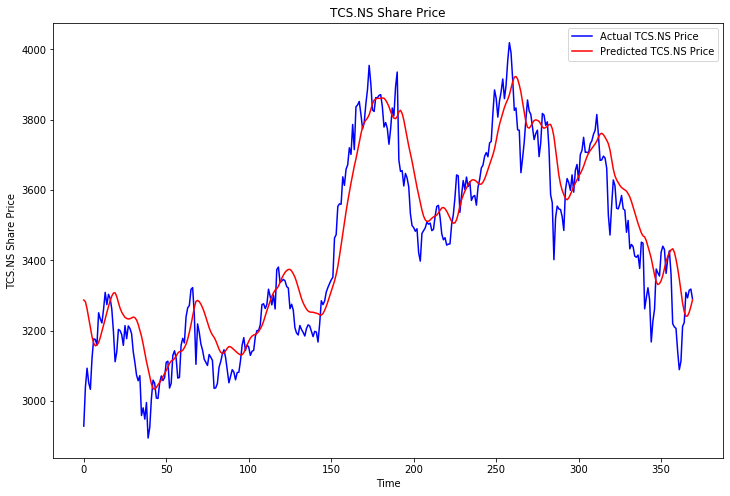

In [41]:
# Make prediction on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
# Plot the test prediction
plt.figure(figsize=(12,8))
plt.plot(actual_prices, color='blue', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='red', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [42]:
# Predict Next day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction : {prediction}')

Prediction : [[3303.303]]
